# Bahceci

In [17]:
# Importing the necessary packages
#!pip install demoji
#!pip install transformers

import ast
import re
import demoji
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import spacy
import textblob
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline

nltk.download('vader_lexicon')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Text Preprocessing

In [2]:
"""
Code for data cleaning.
"""

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')

PATH = 'twitter_training.csv'

twitter_df = pd.read_csv(PATH)

# Run summary/descriptive statistics tests on the data
# Rename the dataframe to pre_df
pre_df = twitter_df.copy()
print("Head of the dataframe:")
print(pre_df.head())
print("\nDescriptive statistics of the dataframe:")
print(pre_df.describe())

pre_df.columns = ["ID", "Game", "Sentiment", "Text"]

# Determine if there are missing values
missing_values = pre_df.isnull().sum()
print("\nMissing values in the dataframe:")
print(missing_values)

# Drop rows with missing 'Text' values
pre_df.fillna("", inplace=True)

pre_df["ID"] = pd.to_numeric(pre_df["ID"], errors="coerce")
pre_df["ID"] = pre_df["ID"].fillna(0).astype(int)

print("Dropped na rows.")

# Lowercase the entire text
pre_df['Text'] = pre_df['Text'].str.lower()

# Remove /n from the text
pre_df['Text'] = pre_df['Text'].str.replace(r'\n.*', '', regex=True)

def remove_emojis(text):
    """
    Remove emojis, of course the emojis may effect the analysis
    as there are positive and negative emojis.
    """
    return demoji.replace(text, '')

pre_df['Text'] = pre_df['Text'].apply(remove_emojis)

print("Removed emojis")


#Correcting the spelling errors can help us as we will
#have more data that can be processed and
#it can give us more meaningful results.


# Remove all non-ASCII characters and fill with whitespace
def remove_non_ascii(text):
    """
    Function to remove non-ascii characters
    """
    cleaned_text = ""
    for char in text:
        if ord(char) < 128:
            cleaned_text += char
        else:
            cleaned_text += " "
    return cleaned_text

pre_df["Text"] = pre_df["Text"].apply(remove_non_ascii)

pre_df["Text"] = pre_df["Text"].str.strip()

print(pre_df)

# Tokenize the text and add it as a new column

pre_df['tokenized_text'] = pre_df['Text'].apply(nltk.word_tokenize)

print(pre_df)

print("tokenization done")

# Remove stopwords in the tokenized column

def remove_stopwords_nltk(tokens):
    """
    Remove stopwords nltk.
    """
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return filtered

def remove_stopwords_spacy(tokens):
    """
    Remove stopwords spacy.
    """
    stopwords_set = set(nlp.Defaults.stop_words)
    filtered = [word for word in tokens if word.lower() not in stopwords_set]
    return filtered


pre_df['tokenized_text_nltk'] = pre_df['tokenized_text'].apply(
    remove_stopwords_nltk)
pre_df['tokenized_text_spacy'] = pre_df['tokenized_text'].apply(
    remove_stopwords_spacy)

print(pre_df)
print("Removed stopwords.")

# Adding 4 columns for stem and lemmas. 2 for nltk stopword
# removed column and 2 for plain tokenized column.

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

def lemmatize(tokens):
    """Lemmatizer"""
    return [lemmatizer.lemmatize(token) for token in tokens]

def stem(tokens):
    """Stemmer"""
    return [porter.stem(token) for token in tokens]

pre_df['lemmatized_text'] = pre_df['tokenized_text'].apply(lemmatize)
pre_df['stemmed_text'] = pre_df['tokenized_text'].apply(stem)
pre_df['lemmatized_text_nltk'] = pre_df['tokenized_text_nltk'].apply(lemmatize)
pre_df['stemmed_text_nltk'] = pre_df['tokenized_text_nltk'].apply(stem)

print(pre_df)
print("Lemma and Stem columns added.")

def remove_numbers(tokens):
    """
    Removing numbers.
    """

    return [re.sub(r'\d+', '', word) for word in tokens]

pre_df['lemmatized_text_nltk'] = pre_df['lemmatized_text_nltk'].apply(
    remove_numbers)
print(pre_df)
print("removed numbers")

#Find the non-alphabetic words.

pattern = re.compile(r'[^a-zA-Z]+')

def find_non_alphabetic_words(lst):
    """Function to find non alphabetic words."""
    non_alphabetic_words = []
    for word in lst:
        if pattern.match(word):
            non_alphabetic_words.append(word)
    return non_alphabetic_words

pre_df['non_alphabetic_words'] = pre_df['lemmatized_text_nltk'].apply(
    find_non_alphabetic_words)

pre_df['lemmatized_text_nltk'] = pre_df['lemmatized_text_nltk'].apply(" ".join)

print(pre_df)
print("Found the non-alphabetic words.")


#We see that we only have punctuation at the end.
#After removing them we can only have meaningful part of the text.


#pre_df.to_csv("twitter_output.csv", index=False)

print("the end")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Head of the dataframe:
   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     

Descriptive statistics of the dataframe:
               2401
count  74681.000000
mean    6432.640149
std     3740.423819
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000

Missing values in the dataframe:
ID             0
Game           0
Sentiment      0
Text         686
dtype: int64
Dropped na rows.
Removed emojis
         ID         Game Sentiment  \
0      2401  Bord

In [3]:
class DataCleaner:
    def __init__(self, file_path):
        if isinstance(file_path, str):
            self.file_path = file_path
        else:
            raise ValueError("Input needs to be a string.")

    def read_data(self):
        self.data = pd.read_csv(self.file_path)

        return self.data

    def remove_non_ascii(self, text):
        """Removing non-ascii chars."""
        cleaned_text = ""
        for char in text:
            if ord(char) < 128:
                cleaned_text += char
            else:
                cleaned_text += " "
        return cleaned_text

    def clean_data(self):
        """Cleaning the data"""

        # Rename the dataframe to pre_df
        pre_df = self.data.copy()

        pre_df.columns = ["ID", "Game", "Sentiment", "Text"]

        # Determine if there are missing values
        missing_values = pre_df.isnull().sum()

        # Drop rows with missing 'Text' values
        pre_df.fillna("", inplace=True)
        pre_df["ID"] = pd.to_numeric(pre_df["ID"], errors="coerce")
        pre_df["ID"] = pre_df["ID"].fillna(0).astype(int)

        # Lowercase the entire text
        pre_df["Text"] = pre_df["Text"].str.lower()

        pre_df["Text"] = pre_df["Text"].str.strip()
        pre_df["Words"] = pre_df["Text"].apply(lambda x: word_tokenize(x))

        pre_df["Text"] = pre_df["Text"].apply(self.remove_non_ascii)
        pre_df["Text"] = pre_df["Text"].str.strip()

        self.data = pre_df

        return self.data


    def features(self):
        """Getting the features"""
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(self.data['Text'])

        self.data['Text_length'] = self.data['Text'].apply(len)
        print(self.data)

    def plot_text_length(self):
        """Plotting text length."""
        plt.hist(self.data['Text_length'], bins=20)
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Text Lengths')
        plt.show()

    def tokenizer(self):
        """Tokenization"""
        self.data['tokenized_text'] = self.data['Text'].apply(
            nltk.word_tokenize)
        self.data['tokenized_text'] = self.data['tokenized_text'].apply(
            ' '.join)
        print(self.data)

    def lemmatize(self):
        """Lemmatizer"""
        self.data['lemmatized_text'] = self.data['tokenized_text'].apply(
            lemmatizer.lemmatize)
        self.data['lemmatized_text'] = self.data['lemmatized_text'].apply(
            ' '.join)

    def stem(self):
        """Stemmer"""
        self.data['stemmed_text'] = self.data['lemmatized_text'].apply(
            porter.stem)
        self.data['stemmed_text'] = self.data['stemmed_text'].apply(' '.join)

## 2. Use NLTK/VADER,Textblob and Huggingface for Sentiment Analysis

In [4]:
def score_to_sentiment(score):
    """
    Convert scores to sentiments.
    """
    if score < -0.05:
        return "Negative"
    elif score > 0.05:
        return "Positive"
    else:
        return "Neutral"

In [5]:
sia = SentimentIntensityAnalyzer()


def sentiment_nltk(text):
    """
    Apply sentiment analysis using nltk.
    """
    sentiment = sia.polarity_scores(text)
    return sentiment["compound"]

pre_df["sentiment_nltk"] = pre_df["lemmatized_text_nltk"].apply(sentiment_nltk)
pre_df["sentiment_nltk_word"] = pre_df["sentiment_nltk"].apply(
    score_to_sentiment)

In [6]:
def sentiment_textblob(text):
    """
    Apply sentiment analysis using TextBlob.
    """
    blob = textblob.TextBlob(text)  # Create a TextBlob object
    sentiment_score = blob.sentiment.polarity  # Get the polarity score
    return sentiment_score

pre_df["sentiment_textblob"] = pre_df["lemmatized_text_nltk"].apply(
    sentiment_textblob)
pre_df["sentiment_textblob_word"] = pre_df["sentiment_textblob"].apply(
    score_to_sentiment)

In [ ]:
# This takes more than 30 min to run, I ran it on my laptop.
huggingface_analyzer = pipeline("sentiment-analysis")
def sentiment_huggingface(text):
    """
    Apply sentiment analysis using Huggingface.
    """
    sentiment_score = huggingface_analyzer(text)  # Get the polarity score
    return sentiment_score[0]["label"]

pre_df["sentiment_huggingf"] = pre_df["lemmatized_text_nltk"].swifter.apply(
    sentiment_huggingface)
pre_df["sentiment_huggingf_word"] = pre_df["sentiment_huggingf"].str.title()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
print(pre_df)

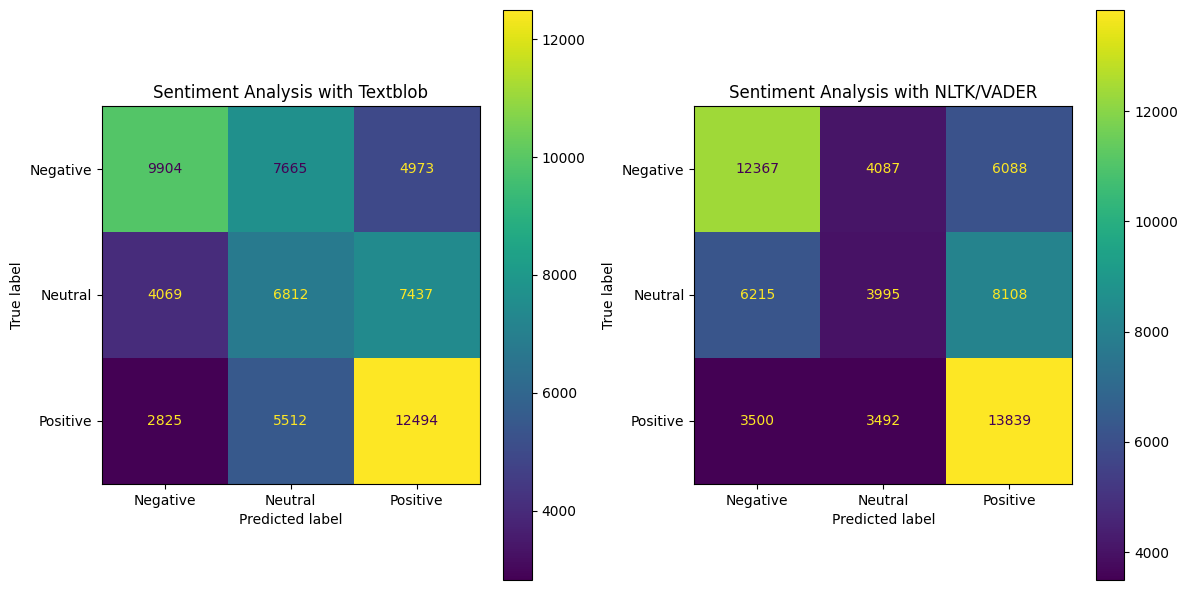

In [22]:
#pre_df.to_csv((PATH / "combined_version.csv"), index=False)

# Drop "Irrelevant" labels for comparison
new_df = pre_df[pre_df["Sentiment"] != "Irrelevant"]

# Visualize the two prediction models with a confusion matrix
confusion_matrix1 = metrics.confusion_matrix(new_df["Sentiment"],
                                             new_df["sentiment_textblob_word"])
confusion_matrix2 = metrics.confusion_matrix(new_df["Sentiment"],
                                             new_df["sentiment_nltk_word"])

labels = ["Negative", "Neutral", "Positive"]

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1,
                                             display_labels=labels)
cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix2,
                                             display_labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cm_display1.plot(ax=axes[0])
axes[0].set_title("Sentiment Analysis with Textblob")

cm_display2.plot(ax=axes[1])
axes[1].set_title("Sentiment Analysis with NLTK/VADER")

plt.tight_layout()
plt.show()


In [ ]:
# Confusion Matrix with Huggingface

confusion_matrix3 = metrics.confusion_matrix(new_df["Sentiment"],
                                             new_df["sentiment_huggingf_word"])

cm_display3 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix3,
                                             display_labels=labels)

cm_display3.plot(cmap=plt.cm.Blues, values_format='')

plt.title('Sentiment Analysis with Huggingface')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

In [20]:
# Running Pylint on this file.
#!pylint application_final_rbb.py


************* Module application_final_rbb
application_final_rbb.py:403:0: C0304: Final newline missing (missing-final-newline)
application_final_rbb.py:41:0: W0105: String statement has no effect (pointless-string-statement)
application_final_rbb.py:216:0: C0115: Missing class docstring (missing-class-docstring)
application_final_rbb.py:223:4: C0116: Missing function or method docstring (missing-function-docstring)
application_final_rbb.py:242:8: W0621: Redefining name 'pre_df' from outer scope (line 56) (redefined-outer-name)
application_final_rbb.py:247:8: W0621: Redefining name 'missing_values' from outer scope (line 65) (redefined-outer-name)
application_final_rbb.py:258:47: W0108: Lambda may not be necessary (unnecessary-lambda)
application_final_rbb.py:247:8: W0612: Unused variable 'missing_values' (unused-variable)
application_final_rbb.py:271:8: C0103: Variable name "X" doesn't conform to snake_case naming style (invalid-name)
application_final_rbb.py:271:8: W0612: Unused vari